## models training

#### LSTM

importing Jupyter notebook from Data_preparation.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


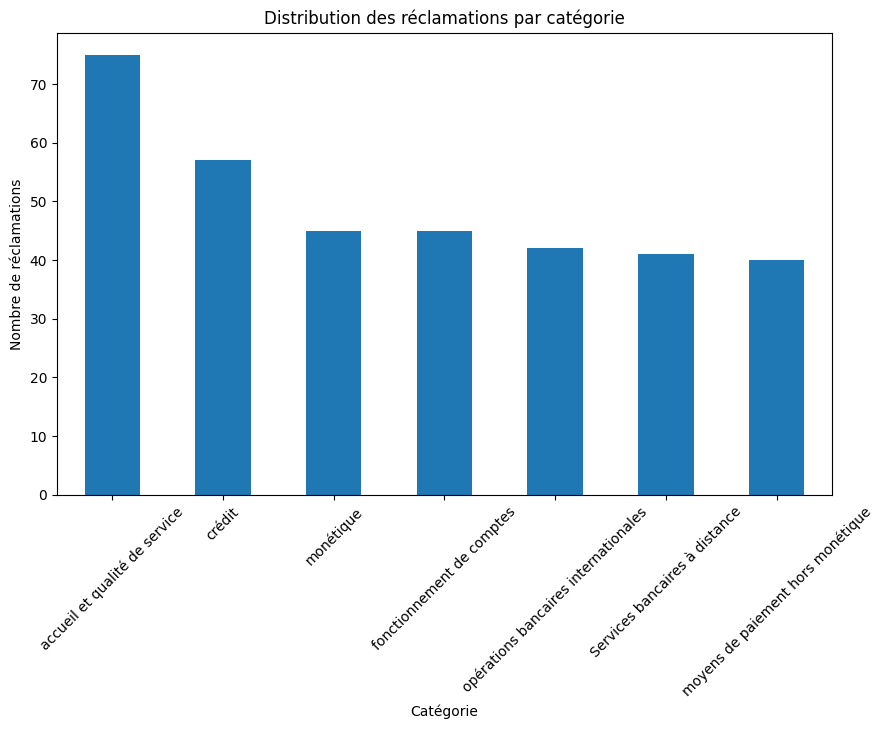

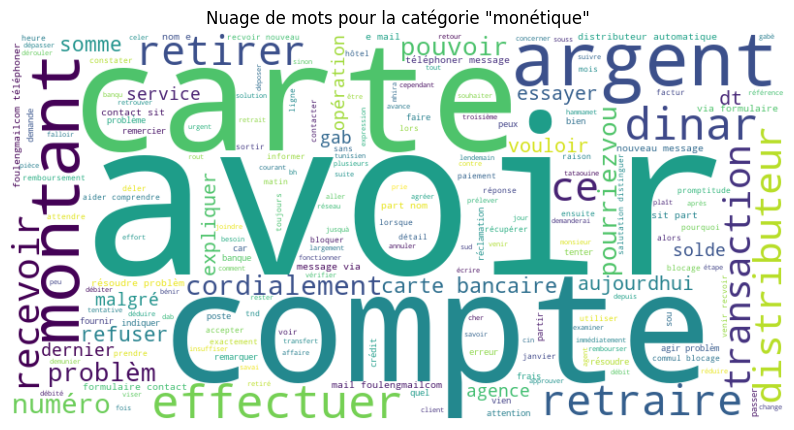

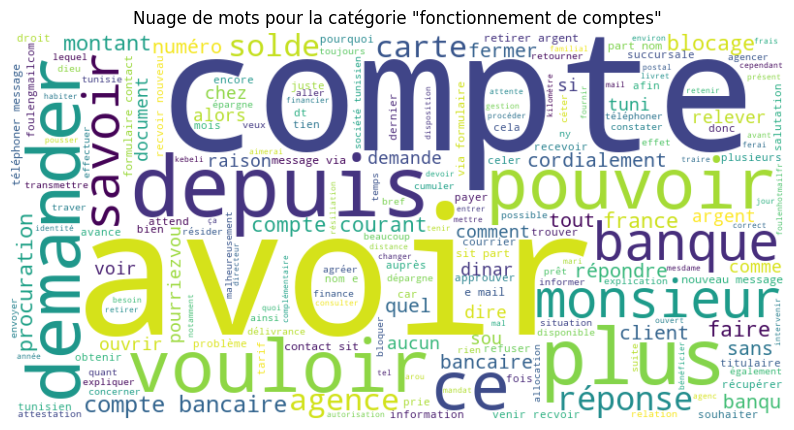

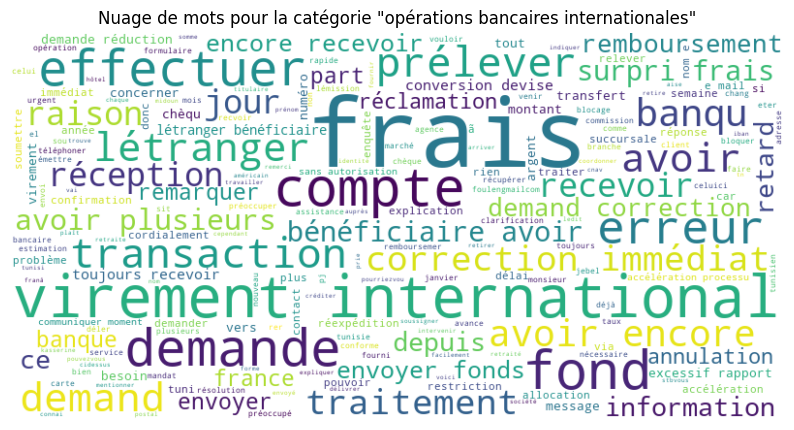

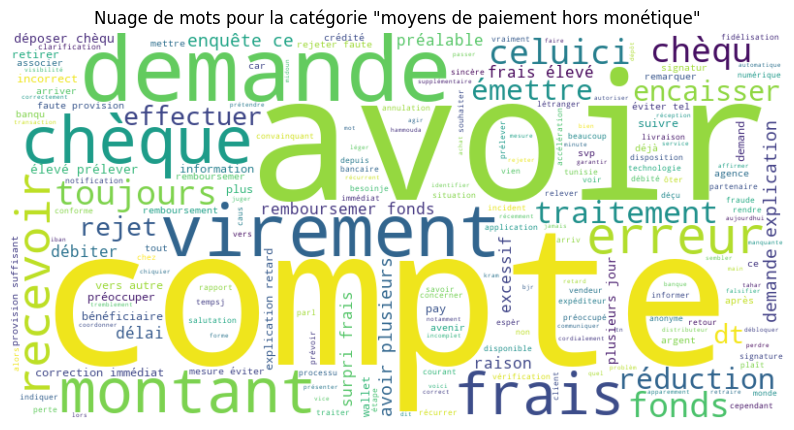

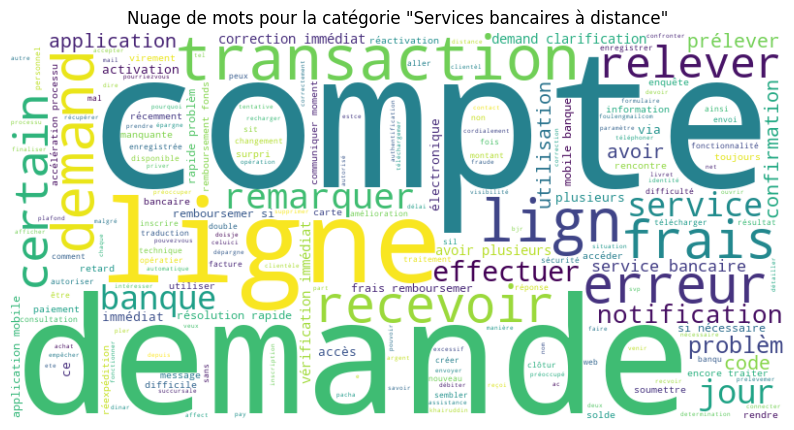

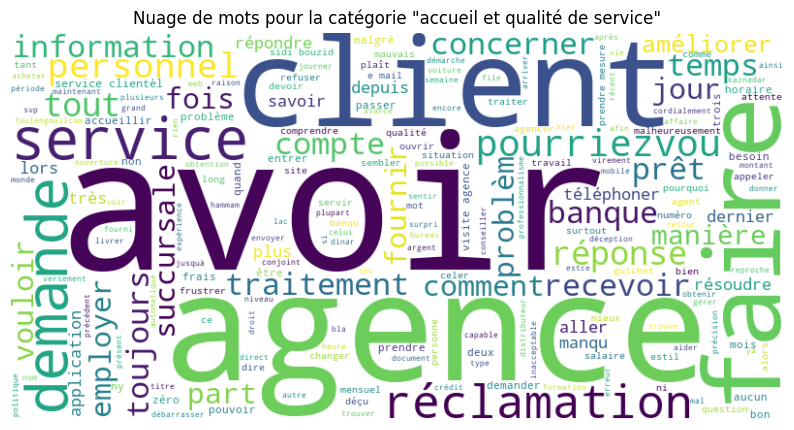

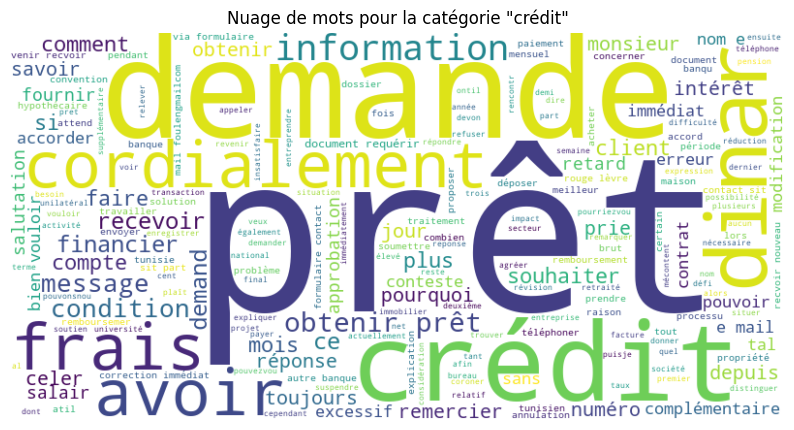

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import import_ipynb
from Data_preparation import *
from imblearn.over_sampling import SMOTE
import optuna
import torch.optim as optim
import numpy as np
import seaborn as sns
import scipy.sparse
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from sklearn.metrics import confusion_matrix

### LSTM

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out


#### Optuna optimiser for hyperparameter

In [77]:
# Objective function for hyperparameter optimization with Optuna
def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512])
    dropout_prob = trial.suggest_float('dropout_prob', 0.3, 0.7)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)

    model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_prob)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Dummy training loop for Optuna
    model.train()
    optimizer.zero_grad()
    data = torch.randn(10, 1, input_dim)
    labels = torch.randint(0, output_dim, (10,))
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [78]:
# Prepare data for PyTorch
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_tfidf, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
output_dim = len(np.unique(y_train_encoded))

X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [109]:
# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best hyperparameters: ", study.best_params)

# Extract best hyperparameters
hidden_dim = study.best_params['hidden_dim']
dropout_prob = study.best_params['dropout_prob']
lr = study.best_params['lr']
weight_decay = study.best_params['weight_decay']

[I 2024-05-31 14:07:26,337] A new study created in memory with name: no-name-1dea56ff-770f-47fe-b0d4-5aa833f8fb97
C:\Users\MSI\AppData\Local\Temp\ipykernel_12936\3262381790.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\MSI\AppData\Local\Temp\ipykernel_12936\3262381790.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
[I 2024-05-31 14:07:26,347] Trial 0 finished with value: 2.05059814453125 and parameters: {'hidden_dim': 64, 'dropout_prob': 0.557784915284752, 'lr': 0.000183058977095768, 'weight_decay': 0.00012151732004314748}. Best is trial

Best hyperparameters:  {'hidden_dim': 64, 'dropout_prob': 0.4539653852815395, 'lr': 0.0002551184615399745, 'weight_decay': 6.049290548491887e-05}


In [110]:
# Prepare the model with the best hyperparameters
model = LSTMModel(input_dim, 64, output_dim, dropout_prob)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()

C:\Users\MSI\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


###### LSTM model training

In [111]:
# Full training with early stopping
num_epochs = 800
train_losses = []
val_losses = []
patience = 25
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}')
    
    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Epoch 1/800, Training Loss: 2.028538562002636, Validation Loss: 1.958271582921346
Epoch 2/800, Training Loss: 1.913525763012114, Validation Loss: 1.9542161453337896
Epoch 3/800, Training Loss: 1.8747791449228923, Validation Loss: 1.9446166356404622
Epoch 4/800, Training Loss: 1.7819948480242775, Validation Loss: 1.9243471395401728
Epoch 5/800, Training Loss: 1.6911872171220326, Validation Loss: 1.8839507386797951
Epoch 6/800, Training Loss: 1.6343577929905482, Validation Loss: 1.8319831235068185
Epoch 7/800, Training Loss: 1.544103809765407, Validation Loss: 1.770703951517741
Epoch 8/800, Training Loss: 1.5035031806854975, Validation Loss: 1.718881300517491
Epoch 9/800, Training Loss: 1.4267343907129197, Validation Loss: 1.674204877444676
Epoch 10/800, Training Loss: 1.3643115134466262, Validation Loss: 1.6417154244014196
Epoch 11/800, Training Loss: 1.3161071028028215, Validation Loss: 1.6068619716735113
Epoch 12/800, Training Loss: 1.2485977751868111, Validation Loss: 1.5756474903651

#### BI-LSTM

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

##### BiLSTM model definition with layer normalization and dropout

In [3]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob, num_layers):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.layer_norm(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

##### Objective function for hyperparameter optimization with Optuna

In [13]:
def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512])
    dropout_prob = trial.suggest_float('dropout_prob', 0.3, 0.7)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    l1_lambda = trial.suggest_loguniform('l1_lambda', 1e-5, 1e-3)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    model = BiLSTMModel(input_dim, hidden_dim, output_dim, dropout_prob, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Simulate a training cycle
    model.train()
    optimizer.zero_grad()
    data = torch.randn(10, 1, input_dim)
    labels = torch.randint(0, output_dim, (10,))
    outputs = model(data)
    loss = criterion(outputs, labels)

    # L1 regularization
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    loss += l1_lambda * l1_norm

    loss.backward()
    optimizer.step()
    return loss.item()

# Prepare data for PyTorch
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_tfidf, y)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

input_dim = X_tfidf.shape[1]
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
output_dim = len(np.unique(y_train_encoded))

X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters: ", study.best_params)

# Extract best hyperparameters
hidden_dim = study.best_params['hidden_dim']
dropout_prob = study.best_params['dropout_prob']
lr = study.best_params['lr']
weight_decay = study.best_params['weight_decay']
l1_lambda = study.best_params['l1_lambda']
num_layers = study.best_params['num_layers']

# Prepare the model with the best hyperparameters
model = BiLSTMModel(input_dim, hidden_dim, output_dim, dropout_prob, num_layers)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

#Best hyperparameters:  {'hidden_dim': 128, 'dropout_prob': 0.30328370538170063, 'lr': 1.018827990446796e-05, 'weight_decay': 0.00012440272520964702, 'l1_lambda': 1.0209545539304384e-05, 'num_layers': 1}
#best of the best Best hyperparameters:  {'hidden_dim': 256, 'dropout_prob': 0.6940775997194615, 'lr': 5.078174080423839e-05, 'weight_decay': 1.0129257140693974e-05, 'l1_lambda': 1.0962964811775809e-05, 'num_layers': 1}

[I 2024-06-05 14:30:26,002] A new study created in memory with name: no-name-f50f503b-44e3-414a-8a8a-d8d047c52438
C:\Users\MSI\AppData\Local\Temp\ipykernel_24388\1451812206.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\MSI\AppData\Local\Temp\ipykernel_24388\1451812206.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
C:\Users\MSI\AppData\Local\Temp\ipykernel_24388\1451812206.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

Best hyperparameters:  {'hidden_dim': 256, 'dropout_prob': 0.6940775997194615, 'lr': 5.078174080423839e-05, 'weight_decay': 1.0129257140693974e-05, 'l1_lambda': 1.0962964811775809e-05, 'num_layers': 1}


C:\Users\MSI\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


#####  Full training with early stopping

In [14]:
num_epochs = 800
train_losses = []
val_losses = []
patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        
        # L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}')
    
    scheduler.step(epoch_val_loss)  # Step the scheduler

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break


Epoch 1/800, Training Loss: 2.976644708934857, Validation Loss: 1.899219897728932
Epoch 2/800, Training Loss: 2.928622623880163, Validation Loss: 1.8532763764828066
Epoch 3/800, Training Loss: 2.821435522968178, Validation Loss: 1.8096037605140782
Epoch 4/800, Training Loss: 2.79944734352486, Validation Loss: 1.7689115684243697
Epoch 5/800, Training Loss: 2.697609229698493, Validation Loss: 1.7298841582068913
Epoch 6/800, Training Loss: 2.6755413151566922, Validation Loss: 1.689830814735799
Epoch 7/800, Training Loss: 2.6170556629711017, Validation Loss: 1.6461253558533102
Epoch 8/800, Training Loss: 2.5624803600259307, Validation Loss: 1.60577377035648
Epoch 9/800, Training Loss: 2.531431186426563, Validation Loss: 1.5615461310253869
Epoch 10/800, Training Loss: 2.50803543501394, Validation Loss: 1.5167395283904257
Epoch 11/800, Training Loss: 2.427302832174691, Validation Loss: 1.4772852840302866
Epoch 12/800, Training Loss: 2.411951160560837, Validation Loss: 1.4381747260878357
Epoc

#### BERT

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import get_linear_schedule_with_warmup
import sentencepiece
from transformers import AlbertTokenizer, AlbertForSequenceClassification

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(set(y)))





C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
import torchtext.vocab as vocab
import os
import shutil

# Chargement des embeddings de GloVe
glove = vocab.GloVe(name='6B', dim=100)

def get_mean_embeddings(texts):
    embeddings = []
    for tokens in texts:
        word_embeddings = [glove[word.lower()] for word in tokens if word.lower() in glove.stoi]
        if word_embeddings:
            embedded_text = torch.mean(torch.stack(word_embeddings), dim=0)
        else:
            embedded_text = torch.zeros(glove.dim)
        embeddings.append(embedded_text)
    return torch.stack(embeddings)

C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [5]:
class AdvancedTextClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes, layer_sizes, dropout_rate):
        super(AdvancedTextClassifier, self).__init__()
        layers = []
        input_dim = embedding_dim
        
        for size in layer_sizes:
            layers.append(nn.Linear(input_dim, size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout_rate))
            input_dim = size
        
        layers.append(nn.Linear(input_dim, num_classes))
        layers.append(nn.LogSoftmax(dim=1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [17]:
def objective(trial):
    # Hyperparameters to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    layer_sizes = trial.suggest_categorical("layer_sizes", [
        [256, 128], [512, 256, 128], [1024, 512, 256]
    ])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
   
    
    model = AdvancedTextClassifier(embedding_dim=100, num_classes=len(set(y_train_encoded)), layer_sizes=layer_sizes, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()
    
    # Training loop with early stopping
    best_val_accuracy = 0
    patience, trials = 10, 0
    
    for epoch in range(50):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        # Validation phase
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                predictions = torch.argmax(output, dim=1)
                correct += (predictions == target).sum().item()
                total += target.size(0)

        val_accuracy = correct / total
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                break  # Early stopping

    return best_val_accuracy

In [18]:
# Préparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Encodage des étiquettes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Supposons que X_train, X_val et X_test sont déjà définis
X_train_embeddings = get_mean_embeddings(X_train)
X_val_embeddings = get_mean_embeddings(X_val)
X_test_embeddings = get_mean_embeddings(X_test)

# Conversion des étiquettes en tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train_embeddings, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_embeddings, y_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_embeddings, y_test_tensor), batch_size=32, shuffle=False)


In [19]:
# Run hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Configuration du modèle avec les meilleurs paramètres
final_model = AdvancedTextClassifier(embedding_dim=100, num_classes=len(set(y_train_encoded)), layer_sizes=trial.params["layer_sizes"], dropout_rate=trial.params["dropout_rate"])
optimizer = optim.Adam(final_model.parameters(), lr=trial.params["lr"])
criterion = nn.NLLLoss()


[I 2024-06-04 17:35:04,337] A new study created in memory with name: no-name-662db6e5-2baf-460b-bc1d-f19e4a650bb7
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 128] which is of type list.
  warnings.warn(message)
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128] which is of type list.
  warnings.warn(message)
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1024, 512, 256] which is of type list.
  warnings.warn(message)
C:\Users\MSI\A

Best trial:
  Value:  0.6785714285714286
  Params: 
    dropout_rate: 0.44191077892081543
    layer_sizes: [1024, 512, 256]
    lr: 0.001464434524180622


In [20]:
# Entraînement avec les meilleurs paramètres
train_losses = []
val_losses = []
for epoch in range(30):  # Augmenter le nombre d'époques si nécessaire
    final_model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = final_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation à la fin de chaque époque
    final_model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            output = final_model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == target).sum().item()
            total += target.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {correct / total}')

Epoch 1: Train Loss: 1.9877338707447052, Validation Loss: 1.9337395429611206, Validation Accuracy: 0.25
Epoch 2: Train Loss: 1.3223004937171936, Validation Loss: 1.950029730796814, Validation Accuracy: 0.25
Epoch 3: Train Loss: 0.9994516968727112, Validation Loss: 1.838370442390442, Validation Accuracy: 0.25
Epoch 4: Train Loss: 0.8089390769600868, Validation Loss: 1.6620692014694214, Validation Accuracy: 0.32142857142857145
Epoch 5: Train Loss: 0.5711579620838165, Validation Loss: 1.5915898084640503, Validation Accuracy: 0.39285714285714285
Epoch 6: Train Loss: 0.5061092376708984, Validation Loss: 1.5755189657211304, Validation Accuracy: 0.42857142857142855
Epoch 7: Train Loss: 0.3924137745052576, Validation Loss: 1.4496172666549683, Validation Accuracy: 0.5714285714285714
Epoch 8: Train Loss: 0.3862731494009495, Validation Loss: 1.4667502641677856, Validation Accuracy: 0.5357142857142857
Epoch 9: Train Loss: 0.22772048227488995, Validation Loss: 1.574053406715393, Validation Accuracy

### Model choice


##### lstm 

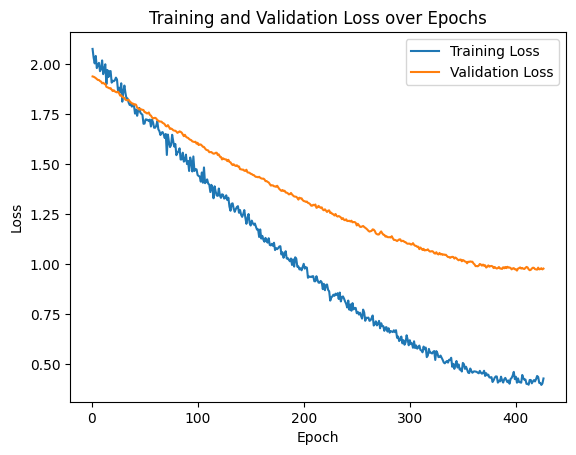

In [103]:
# Plot training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [104]:
# Prepare test data for PyTorch
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [105]:
# Evaluate the model
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())


In [106]:
# Decode labels
predicted_labels = label_encoder.inverse_transform(predictions)
true_labels = label_encoder.inverse_transform(true_labels)


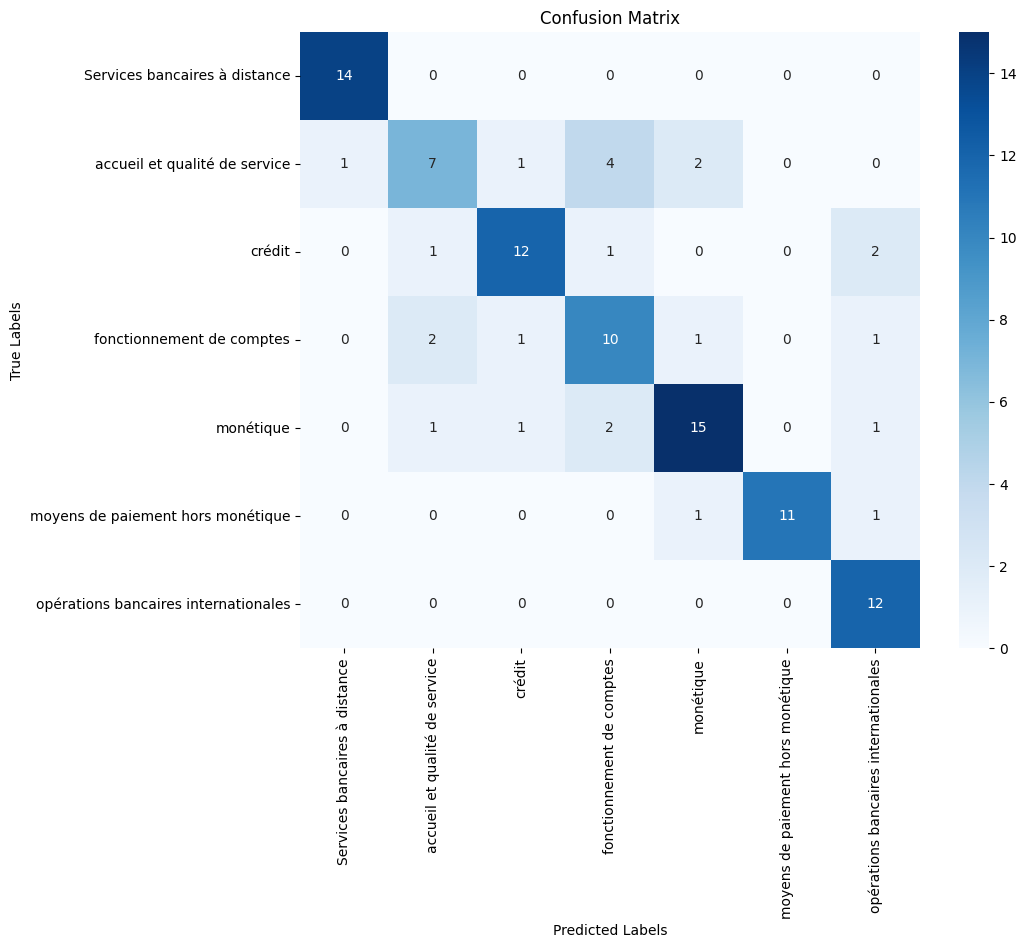

In [107]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [108]:
# Classification report
print(classification_report(true_labels, predicted_labels))

                                      precision    recall  f1-score   support

       Services bancaires à distance       0.93      1.00      0.97        14
       accueil et qualité de service       0.64      0.47      0.54        15
                              crédit       0.80      0.75      0.77        16
           fonctionnement de comptes       0.59      0.67      0.62        15
                           monétique       0.79      0.75      0.77        20
   moyens de paiement hors monétique       1.00      0.85      0.92        13
opérations bancaires internationales       0.71      1.00      0.83        12

                            accuracy                           0.77       105
                           macro avg       0.78      0.78      0.77       105
                        weighted avg       0.78      0.77      0.77       105



##### Bilstm

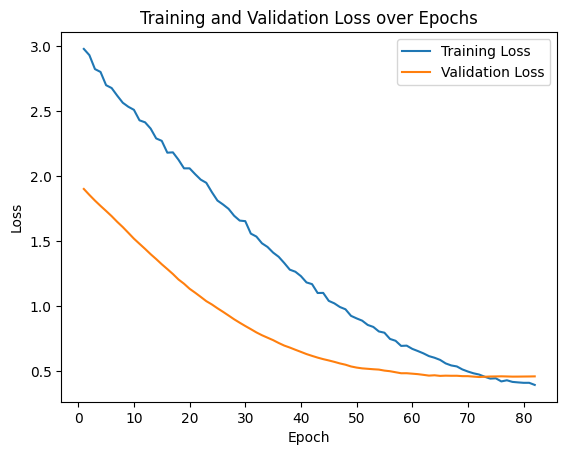

Classification Report:
                                      precision    recall  f1-score   support

       Services bancaires à distance       0.93      0.87      0.90        15
       accueil et qualité de service       0.85      0.69      0.76        16
                              crédit       0.69      0.82      0.75        11
           fonctionnement de comptes       0.78      0.78      0.78         9
                           monétique       0.85      0.92      0.88        12
   moyens de paiement hors monétique       1.00      0.90      0.95        10
opérations bancaires internationales       0.75      1.00      0.86         6

                            accuracy                           0.84        79
                           macro avg       0.83      0.85      0.84        79
                        weighted avg       0.84      0.84      0.84        79



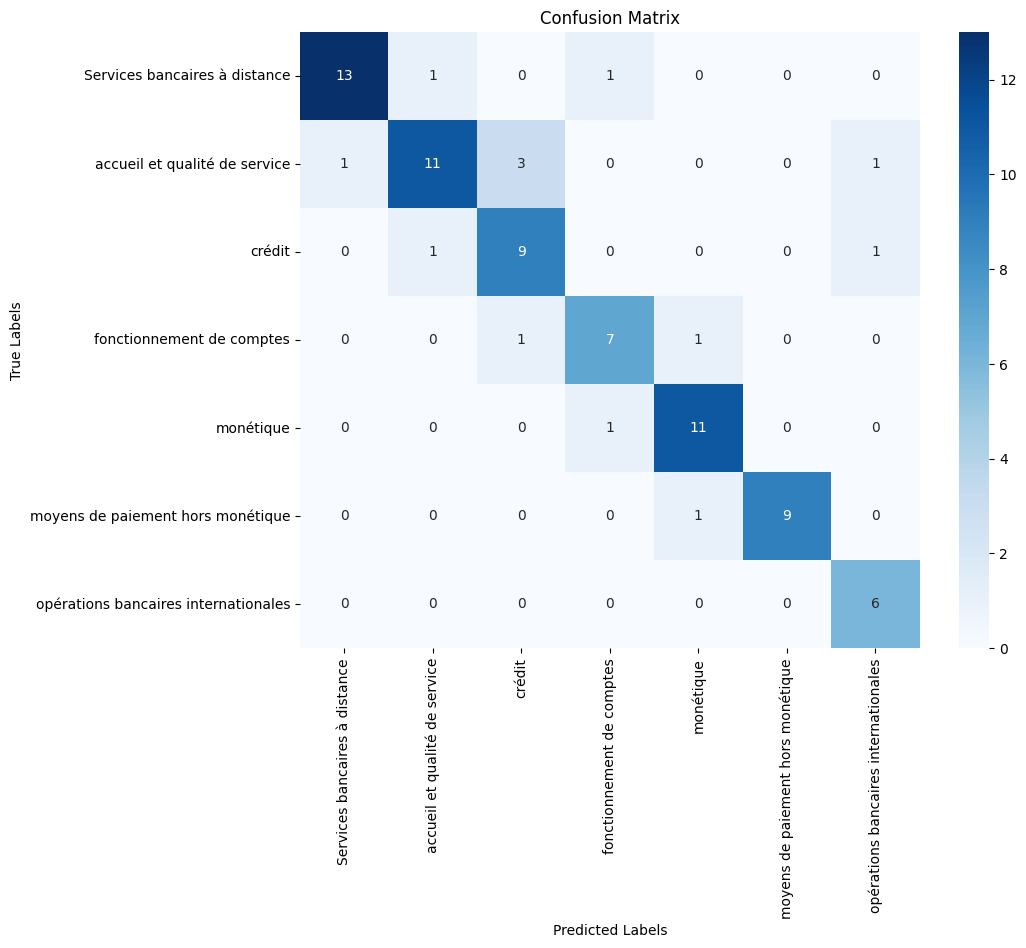

In [15]:
# Plot training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Evaluate the model on test data

model.eval()

X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

predictions, true_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

predicted_labels = label_encoder.inverse_transform(predictions)
true_labels = label_encoder.inverse_transform(true_labels)

#classification report

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### BERT


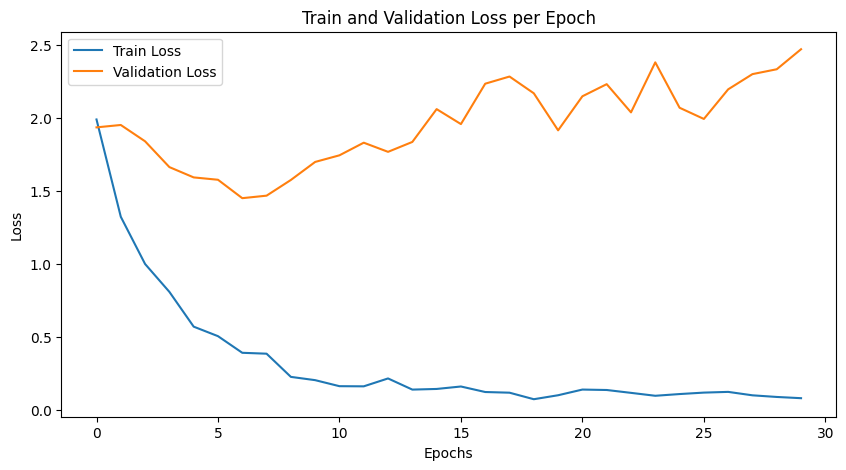

Classification Report:
                                      precision    recall  f1-score   support

       Services bancaires à distance       0.80      0.57      0.67         7
       accueil et qualité de service       0.64      0.47      0.55        19
                              crédit       0.82      0.64      0.72        14
           fonctionnement de comptes       0.38      0.60      0.46         5
                           monétique       0.73      0.67      0.70        12
   moyens de paiement hors monétique       0.62      1.00      0.77         5
opérations bancaires internationales       0.33      0.57      0.42         7

                            accuracy                           0.61        69
                           macro avg       0.62      0.65      0.61        69
                        weighted avg       0.66      0.61      0.62        69



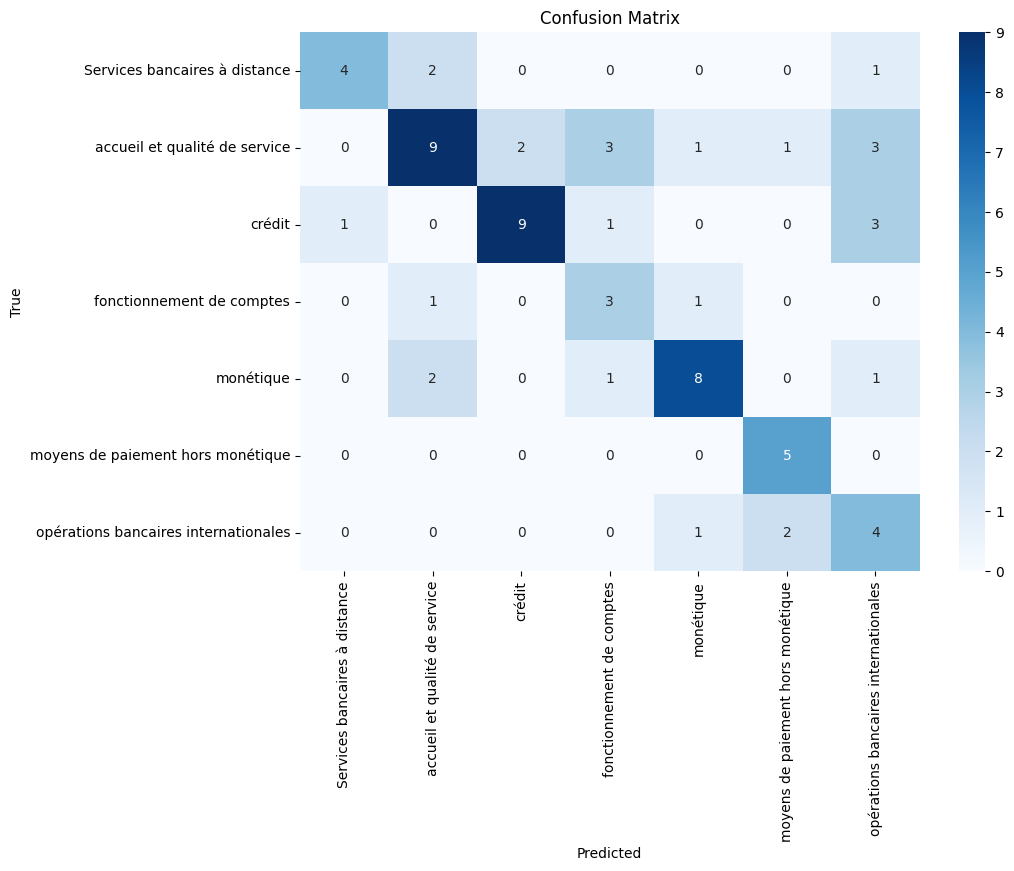

In [21]:
# Plotting train and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss per Epoch')
plt.legend()
plt.show()

# Evaluation finale sur les données de test
final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, target in test_loader:
        output = final_model(data)
        predictions = torch.argmax(output, dim=1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Model saving

##### Bilstm

In [17]:
torch.save(model.state_dict(), "C:\\Users\\MSI\\Documents\\PFE_firas\\models_savings\\bilstm_model.pth")

### Save of vectorisation and label encoder

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pickle
label_encoder = LabelEncoder()
label_encoder.fit(y.unique())

# Sauvegarder le vectorizer et le label encoder
with open("C:\\Users\\MSI\\Documents\\PFE_firas\\input_data\\vectorizer.pkl", 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open("C:\\Users\\MSI\\Documents\\PFE_firas\\input_data\\label_encoder.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)

### model prediction for type

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import LinearSVC


##### preparation de données

In [4]:
y1 = data_frame["Type"]
y1 = y1.replace({
    'réclamation': 'Réclamation',
    'requête': 'Requête',
    'Requête ': 'Requête'})

label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(y1)

# Rééchantillonnage avec SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y1_encoded)

# Division des données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


##### Fonction pour évaluer et tracer les performances

In [4]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    print("Training Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

    print("Validation Set:")
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))

    print("Test Set:")
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    test_score = model.score(X_test, y_test)

    return train_score, val_score, test_score


##### GridSearch pour les deux models naive bayes et LinearSVC

In [5]:
# modèle Naive Bayes
param_grid_nb = {'alpha': [0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='f1_weighted')
grid_nb.fit(X_train, y_train)
print("Best parameters for Naive Bayes:", grid_nb.best_params_)

train_score_nb, val_score_nb, test_score_nb = evaluate_model(grid_nb.best_estimator_, X_train, y_train, X_val, y_val, X_test, y_test)

# SVM avec régularisation L1 et L2
param_grid_svm = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'dual': [False]  
}

grid_svm = GridSearchCV(LinearSVC(), param_grid_svm, cv=5, scoring='f1_weighted')
grid_svm.fit(X_train, y_train)
print("Best parameters for SVM:", grid_svm.best_params_)

train_score_svm, val_score_svm, test_score_svm = evaluate_model(grid_svm.best_estimator_, X_train, y_train, X_val, y_val, X_test, y_test)



Best parameters for Naive Bayes: {'alpha': 0.1}
Training Set:
[[175   2]
 [  6 192]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       177
           1       0.99      0.97      0.98       198

    accuracy                           0.98       375
   macro avg       0.98      0.98      0.98       375
weighted avg       0.98      0.98      0.98       375

Validation Set:
[[38  0]
 [ 4 38]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        38
           1       1.00      0.90      0.95        42

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

Test Set:
[[53  0]
 [ 0 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        28

    accuracy                     

C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\MSI\anaconda3\envs\env_notebook\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


##### Plot pour le score

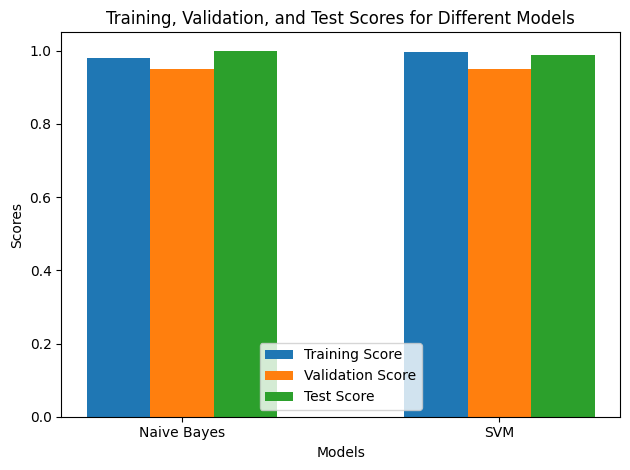

In [6]:
# Tracer les scores
models = ['Naive Bayes', 'SVM']
train_scores = [train_score_nb, train_score_svm]
val_scores = [val_score_nb, val_score_svm]
test_scores = [test_score_nb, test_score_svm]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_scores, width, label='Training Score')
rects2 = ax.bar(x, val_scores, width, label='Validation Score')
rects3 = ax.bar(x + width, test_scores, width, label='Test Score')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Training, Validation, and Test Scores for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.show()

##### Model save

In [7]:
import pickle
label_encoder_type = LabelEncoder()
y1_encoded = label_encoder_type.fit_transform(y1)
with open("C:\\Users\\MSI\\Documents\\PFE_firas\\input_data\\label_encoder_type.pkl", 'wb') as f:
    pickle.dump(label_encoder_type, f)

In [10]:
with open("C:\\Users\\MSI\\Documents\\PFE_firas\\models_savings\\naive_bayes_model.pkl", 'wb') as model_file:
    pickle.dump(grid_nb.best_estimator_, model_file)
